<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe61622](https://jckantor.github.io/cbe61622);
content is available [on Github](https://github.com/jckantor/cbe61622.git).*


<!--NAVIGATION-->
< [10.12 Test Driven Development](https://jckantor.github.io/cbe61622/10.12-Test-Driven-Development.html) | [Contents](toc.html) | [A.0 Python Source Library](https://jckantor.github.io/cbe61622/A.00-Appendices.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe61622/blob/master/docs/10.13-Computer-Vision-Application.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe61622/10.13-Computer-Vision-Application.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 10.13 Computer Vision Case Study: Creating an Application


## 10.13.1 Application

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import defaultdict
from scipy import ndimage

class Channel():
    
    colormaps = {"k":"Greys", "r":"Reds", "g":"Greens", "b":"Blues"}
    
    def __init__(self, data=None):
        if data is None:
            self.data = np.zeros((0,0), dtype=np.uint8)
        else:
            self.data = self.import_array(data)
        
    def __call__(self, data=None):
        """"Set and return current channel data."""
        if not (data is None):
            self.data = self.import_array(data)
        return self.data
    
    def import_array(self, data):
        data = np.where(data < 0, 0, data)
        data = np.where(data > 255, 255, data)
        return data.astype(np.uint8)

    @property
    def histogram(self):
        return cv2.calcHist([self.data], [0], None, [256], [0, 255]).flatten()
    
    def show(self, ax, color='k'):
        ax.imshow(self.data, cmap=self.colormaps[color])
        
    def show_histogram(self, ax, color='k'):
        bins = np.arange(0, 256)
        ax.fill_between(bins, self.histogram, 0, color=color, alpha=0.3)
        
    def equalize_histogram(self):
        self.data = cv2.equalizeHist(self.data)
    
    def blur_Gaussian(self, ksize=3):
        self.data = cv2.GaussianBlur(self.data, (ksize, ksize), 0)
        
    def threshold(self, T):
        T, self.data = cv2.threshold(self.data, T, 255, cv2.THRESH_BINARY)
        
    def threshold_otsu(self):
        T, self.data = cv2.threshold(self.data, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return T
    
    def morph_close(self, iterations=1, kernel=np.ones((3,3))):
        ret = cv2.dilate(self.data, kernel=kernel, iterations=iterations)
        self.data = cv2.erode(ret, kernel=kernel, iterations=iterations)
    
    def morph_open(self, iterations=1, kernel=np.ones((3,3))):
        ret = cv2.erode(self.data, kernel=kernel, iterations=iterations)
        self.data = cv2.dilate(ret, kernel=kernel, iterations=iterations)
        
    def find_particles(self):
        structure = np.ones((3, 3))
        labels, particle_count = ndimage.measurements.label(self.data, structure=structure)
        
        # locate centers of mass
        centers_of_mass = ndimage.center_of_mass(self.data, labels, np.arange(1, particle_count + 1))
        
        # get slices containting particles
        slices = ndimage.find_objects(labels)
        
        # get raster points for each particle
        points = []
        Y, X = labels.shape
        for n in range(len(centers_of_mass)):
            locs = labels==(n+1)
            points.append(np.array([(x, y) for x in range(X) for y in range(Y) if locs[y, x]]))         
        return centers_of_mass, slices, points


class Particle():
    
    def __init__(self, center_of_mass, slice, raster_points):
        self.yc, self.xc = center_of_mass
        yslice, xslice = slice
        self.x1, self.y1 = xslice.start, yslice.start
        self.x2, self.y2 = xslice.stop, yslice.stop
        self.w = self.x2 - self.x1
        self.h = self.y2 - self.y1
        self.size = np.sqrt(self.w * self.h)
        self.raster_points = raster_points
        
    def show(self, ax):
        ya = self.y1
        yb = self.y2
        xa = self.x1
        xb = self.x2
        ax.plot([xa, xb, xb, xa, xa], [yb, yb, ya, ya, yb], 'r', lw=1)

        
class Labeler():
    
    def __init__(self):
        self.channels = defaultdict(Channel)
        self.particles = []
    
    def read(self, filepath):
        self.filepath = filepath
        self.img = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
    
    def show(self, ax):
        ax.imshow(self.img)
        ax.set_title(self.filepath)
        ax.set_xlabel("<--- w --->")
        ax.set_ylabel("<--- h --->")
        for p in labeler.particles:
            p.show(ax)
        
    def find_particles(self, filepath, size_range=(0, 1e6)):
        self.read(filepath)
        r = self.img[:, :, 0]
        g = self.img[:, :, 1]
        b = self.img[:, :, 2]
        self.channels['bw'](g - 0.5*b - 0.1*r - 20.0)
        self.channels['bw'].equalize_histogram
        self.channels['bw'].blur_Gaussian(31)
        self.channels['bw'].threshold_otsu()
        self.channels['bw'].morph_close(3)
        self.channels['bw'].morph_open(8)
        centers_of_mass, slices, raster_points = self.channels['bw'].find_particles()
        self.particles = [Particle(centers_of_mass[k], slices[k], raster_points[k]) for k in range(len(centers_of_mass))]
        self.particles = [p for p in self.particles if (p.size >= size_range[0]) and (p.size <= size_range[1])]

## 10.13.2 Demonstrations

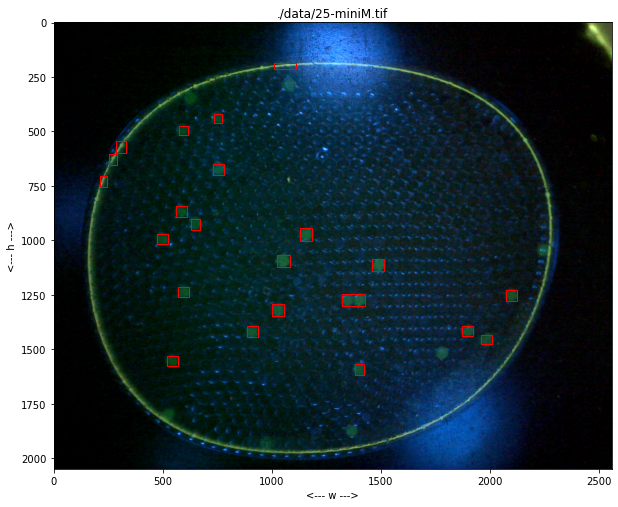

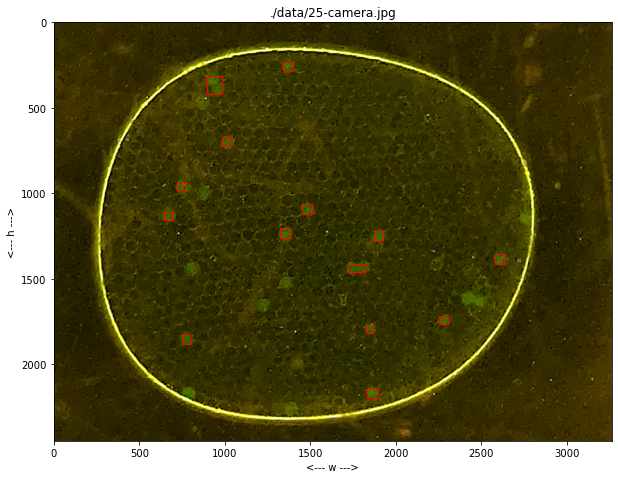

In [56]:
import glob

for filepath in glob.glob("./data/25-*"):
    labeler = Labeler()
    labeler.find_particles(filepath, size_range=(40, 100))
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    labeler.show(ax)

<!--NAVIGATION-->
< [10.12 Test Driven Development](https://jckantor.github.io/cbe61622/10.12-Test-Driven-Development.html) | [Contents](toc.html) | [A.0 Python Source Library](https://jckantor.github.io/cbe61622/A.00-Appendices.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe61622/blob/master/docs/10.13-Computer-Vision-Application.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe61622/10.13-Computer-Vision-Application.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>